In [ ]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import scipy.io
import copy
from itertools import islice
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn.init as init
from google.colab import files
from io import BytesIO

random.seed(3242023)
torch.manual_seed(3242023) # Seeded with a constant, so that behavior is deterministic.
torch.cuda.manual_seed_all(3242023)

one_hot = True
run_multitest = False
run_training_divergence = True

# torch.use_deterministic_algorithms(True)

if torch.cuda.is_available():
    device = "cuda"
else:
   device = "cpu"


print(f"Pytorch running on {device}")

Pytorch running on cpu


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def cov(mat):
    """
    mat should be a matrix whose rows are separate samples.
    """
    xbar = torch.zeros(mat.size()[1], device=device)
    for row in mat:
        xbar += row
    xbar /= mat.size()[0]
    matdelta = [row-xbar for row in mat]
    print(f"Squares of L2 norms of X-Xbar: {[torch.nansum(torch.square(row)) for row in matdelta]}")
    ans = []
    for row in matdelta:
        unsqueezed_row = row.unsqueeze(0)
        ans.append(torch.matmul(unsqueezed_row.t(), unsqueezed_row))
    return sum(ans)/(len(ans)-1)

def get_eig_of_differences(data):
    """
    data should be a 2-dimensional tensor whose rows are the trained parameters
    of an ML model, with one training per row. If you have a model with N
    parameters that you run M times, data should be of size (M, N). Returns a
    1-dimensional, M-element tensor whose entries are the eigenvalues (in no
    particular order) of the square matrix calculated by subtracting the mean
    of the input rows from each individual row, then right-multiplying that
    matrix by its transpose. This guarantees a M by M square matrix, which
    means that calculating the eigenvalues is surprisingly fast, even with
    reasonably large models.
    """
    mu = torch.mean(data, 0, keepdim=True).expand(data.size()[0], -1)
    deviation_data = data-mu
    square_data = torch.matmul(deviation_data, deviation_data.transpose(0, 1))
    eig = torch.linalg.eigvals(square_data)
    return eig.real

def get_l2_norm(data):
    mu = torch.mean(data, 0, keepdim=True).expand(data.size()[0], -1)
    deviation_data = data-mu
    total_norm = 0.0
    for row in deviation_data:
        norm = torch.norm(row, p=2)
        norm *= norm
        total_norm += norm
    return total_norm / data.size()[0]

def get_sample_covariance_eigs(data):
    cov = torch.cov(data.t()) # torch.cov expects columns, not rows, to be individual trials
    eig = torch.linalg.eigvals(cov)
    return eig.real

def get_eig_of_differences_fast(data, num_eigvals=-1):
    """
    ONLY USE THIS FUNCTION AFTER RUNNING AN EXCESSIVE (>10,000) NUMBER OF TRIALS
    Acts similarly to get_eig_of_differences, except that it averages the N by N
    square matrix whose eigenvalues are calculated with its transpose, then uses
    torch.lobpcg to estimate only the num_eigvals largest eigenvalues, instead
    of calculating all of them. num_eigvals defaults to data.size()[0]
    """
    mu = torch.mean(data, 0, keepdim=True).expand(data.size()[0], -1)
    deviation_data = data-mu
    square_data = torch.matmul(deviation_data, deviation_data.transpose(0, 1))
    square_data = (square_data+square_data.transpose(0, 1))/2
    eigvals_to_gen = data.size()[0] if num_eigvals == -1 else num_eigvals
    eig = torch.lobpcg(square_data, k=eigvals_to_gen)
    return eig[0]

def generate_gaussian_noise(cov, noise_mult=1, copies = 1):
    U, S, V = torch.linalg.svd(cov)
    Sprime = torch.sqrt(S)
    print("Noise: sum of sqrts of svd of cov:")
    print(torch.sum(Sprime))
    Sprime *= torch.nansum(Sprime)
    Sprime = torch.sqrt(Sprime)
    noise_list = []
    for i in range(copies): # TODO this may be suboptimal, but I'm not sure the obvious speedup doesn't change the output
        noise = torch.randn(cov.size()[0], device=device)*noise_mult
        noise = torch.matmul(noise, torch.diag(Sprime))
        noise = torch.matmul(U, noise)
        noise_list.append(noise)
    return torch.stack(noise_list)

def gen_noise2(data,q,noise_mult=0.1):
    """
    Taken wholesale from Aidan's code.
    """
    U, S, V = torch.pca_lowrank(data, q, center=True, niter=2)
    Sprime = torch.sqrt(S)
    Sprime *= torch.nansum(Sprime)
    Sprime = torch.sqrt(Sprime)
   # cov = torch.cov(data.t())
    print("here")
    noise = torch.randn(data.size()[0], device=device)*noise_mult
    print(noise.size())
    temp = torch.diag(Sprime).type(torch.FloatTensor)
    temp = temp.to(device)
    noise = torch.matmul(noise, temp)
    print(noise.size())
    noise = noise.type(torch.DoubleTensor)
    noise = torch.matmul(V.to(device), noise.to(device).float())
    print(noise.size())
    return noise

In [ ]:
def convert_to_one_hot(data): # Taken from https://stackoverflow.com/questions/36960320/convert-a-2d-matrix-to-a-3d-one-hot-matrix-numpy
    """
    WARNING: mutates input, incrementing each value in it by 1
    """
    data += 1
    return np.squeeze((np.arange(data.max()) == data[...,None]-1).astype(int))

train_mat = scipy.io.loadmat('data_cifar100_train.mat', verify_compressed_data_integrity=False) # data_cifar100_train.mat is the right file
print(train_mat.keys())
train_mat = train_mat["data"]
print(type(train_mat))
print(train_mat.shape)
ans_mat = scipy.io.loadmat('label_train.mat')
ans_mat = ans_mat["data"]
print(ans_mat.shape)
print(ans_mat[:12])
ans_mat = ans_mat.transpose()
coeffs = np.linalg.lstsq(train_mat, ans_mat)[0]
print(coeffs.shape)
ans = np.matmul(train_mat, coeffs)
print(sum(ans))
print(sum(ans-ans_mat))
if one_hot:
    ans_mat = convert_to_one_hot(ans_mat)

dict_keys(['__header__', '__version__', '__globals__', 'data'])
<class 'numpy.ndarray'>
(50000, 1024)
(1, 50000)
[[6 9 9 ... 9 1 1]]


<ipython-input-3-dc7f53117efe>:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs = np.linalg.lstsq(train_mat, ans_mat)[0]


(1024, 1)
[224601.18354116]
[-398.81645885]


In [ ]:
round_to_n = lambda x, n: 0 if math.isnan(x) or x == 0 else round(x, -int(math.floor(math.log10(x))) + (n - 1)) # Taken from https://stackoverflow.com/questions/3410976/how-to-round-a-number-to-significant-figures-in-python

def create_heatmap(data, x_axis_labels, y_axis_labels, title=None, sig_figs = 2):
    fig, ax = plt.subplots()
    im = ax.imshow(data)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(x_axis_labels)), labels=x_axis_labels)
    ax.set_yticks(np.arange(len(y_axis_labels)), labels=y_axis_labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(y_axis_labels)):
        for j in range(len(x_axis_labels)):
            data_to_display = round_to_n(data[i, j], sig_figs)
            if data_to_display % 1 == 0:
                data_to_display = int(data_to_display)
            text = ax.text(j, i, data_to_display,
                            ha="center", va="center", color="w")

    if title != None:
        ax.set_title(title)
    fig.tight_layout()
    plt.show()

In [ ]:
def get_params(layer):
    return torch.cat((layer.weight.data, layer.bias.data.unsqueeze(1)), 1)

def clip_group_sample_grad(grad_list, max_norm=1.0): # MICROBATCHING IS HERE
    reshaped_grad_list = []
    grad_lengths = []
    for part_grad in grad_list:
        if len(part_grad.shape) == 1:
            reshaped_grad_list.append(part_grad.unsqueeze(1))
            grad_lengths.append(1)
        elif len(part_grad.shape) > 2:
            raise RuntimeError("Gradient is 3-dimensional. That means that this quick gradient-stacking code finally needs to be redone.")
        else:
            grad_lengths.append(part_grad.shape[1])
            reshaped_grad_list.append(part_grad)
    grad_tensor = torch.cat(reshaped_grad_list, 1) # This will fail if the network is more complicated than a linear layer; it will need to be rewritten at some point

    l2_norm = torch.norm(grad_tensor, p=2)
    # print(f"Current norm: {l2_norm}")
    if l2_norm > max_norm:
        # print("Clipping!")
        grad_tensor *= max_norm/l2_norm
    # else:
        # print("Not clipping")

    out_list = []
    grad_idx = 0
    for length in grad_lengths:
        out_list.append(grad_tensor[:, grad_idx:grad_idx+length].squeeze())
        grad_idx += length
    return out_list

def measure_model_stability(models):
    coeffs_list = []

    for model in models:
        coeffs_list.append(np.array(get_params(model)))

    coeffs_list = [i.flatten() for i in coeffs_list]
    coeffs_norms = [math.sqrt(np.dot(i, i)) for i in coeffs_list]

    num_trials = len(models)

    avg_coeff = sum(coeffs_list)/num_trials
    coeff_diffs_list = [i-avg_coeff for i in coeffs_list]
    coeffs_diffs_norms = [math.sqrt(np.dot(i, i)) for i in coeff_diffs_list]

    avg_l2 = sum(coeffs_norms)/num_trials
    avg_l2_deviation = sum(coeffs_diffs_norms)/num_trials

    return avg_l2, avg_l2_deviation

def train_models_divergent_one_step(models_in, optimizers, data_sets, label_sets, measure_stability=True, criterion=nn.CrossEntropyLoss(), test_data=None, test_labels=None, microbatch_size=100, clipping_func = lambda x: x):
    assert len(data_sets) == len(label_sets) and len(data_sets) == len(models_in)
    for i in range(len(data_sets)):
        all_group_sample_gradients = []
        for j in range(0, len(data_sets[i]), microbatch_size):
            microbatch = data_sets[i][j:j+microbatch_size]
            microbatch_ans = label_sets[i][j:j+microbatch_size]

            out = models_in[i](microbatch)
            loss = criterion(out, microbatch_ans)
            loss.backward()

            group_sample_gradients = clipping_func([p.grad.detach().clone() for p in models_in[i].parameters()])

            all_group_sample_gradients.append(group_sample_gradients)
            optimizers[i].zero_grad()

        num_microbatches = len(all_group_sample_gradients) # MICROBATCHING IS HERE
        processed_grads = [sum([idx[k] for idx in all_group_sample_gradients])/num_microbatches for k in range(len(all_group_sample_gradients[0]))]

        for idx, p in enumerate(models_in[i].parameters()):
            p.grad = processed_grads[idx]

        optimizers[i].step()
        if test_data is not None:
            test_out = models_in[i](test_data)
            accuracy = get_accuracy(test_out.detach(), test_labels)
            print(f"Model {i} has an accuracy of {accuracy}")
    if measure_stability:
        return measure_model_stability(models_in)

def train_models_divergent(train_set, train_ans, num_datapoints=10000, num_trials=8, steps=16, microbatch_size=100, test_data=None, test_labels=None, graph_results=True, clipping_threshold=1.0, base_model=None):
    """
    returns a list of tuples. Each tuple represents one epoch and has two
    elements. The first element is the average l2 norm of the models after that
    epoch. The second element is the average deviation in that same epoch.
    """
    if microbatch_size <= 0:
        microbatch_size = num_datapoints
    data_sets, label_sets = random_sample(train_set, train_ans, num_datapoints, num_trials)
    # data_sets, label_sets = random_sample_some_removed(train_set, train_ans, num_datapoints, 1, num_trials)
    data_sets = torch.Tensor(data_sets)
    label_sets = torch.Tensor(label_sets)
    if test_data is not None:
        test_data = torch.Tensor(test_data)
        test_labels = torch.Tensor(test_labels)

    if base_model is None:
        base_model = nn.Linear(1024, 10)
    models = [copy.deepcopy(base_model) for i in range(num_trials)]
    optimizers = [torch.optim.SGD(m.parameters(), lr=0.1) for m in models]

    stability_data = []

    if clipping_threshold <= 0:
        temp_clip_func = lambda x: x
    else:
        temp_clip_func = lambda x: clip_group_sample_grad(x, clipping_threshold)

    for step in range(steps):
        if test_data is not None:
            print(f"Now beginning epoch {step}")
        stability_data.append(train_models_divergent_one_step(models, optimizers, data_sets, label_sets, True, test_data=test_data, test_labels=test_labels, microbatch_size=microbatch_size, clipping_func=temp_clip_func))

    if graph_results:
        l2_fractional_deviation = [data[1]/data[0] for data in stability_data]
        plt.plot([0] + l2_fractional_deviation)
    return (stability_data, models)

In [ ]:
def train_models_checkpointed(train_set, train_ans, test_set=None, test_ans=None, num_datapoints=10000, num_models=8, epochs_per_group=10, total_groups=10, microbatch_size=0, clipping_threshold=0, graph_results=False):
    current_model = None
    data = []
    for i in range(total_groups):
        print(f"\nBeginning training group {i} of {total_groups}\n\n")
        out = train_models_divergent(train_set, train_ans, num_datapoints, num_models, epochs_per_group, microbatch_size, test_set, test_ans, False, clipping_threshold, current_model)
        current_model = out[1][0]
        data.append(out[0])

    if graph_results:
        for trial in data:
            plt.plot([epoch[1]/epoch[0] for epoch in trial])
        plt.show()
        for trial in data:
            plt.plot([epoch[1] for epoch in trial])
        plt.show() # TODO this can and should be prettier
    return data


Beginning training group 0 of 8


Now beginning epoch 0
Model 0 has an accuracy of 0.2995
Model 1 has an accuracy of 0.3156
Model 2 has an accuracy of 0.2992
Model 3 has an accuracy of 0.313
Model 4 has an accuracy of 0.292
Model 5 has an accuracy of 0.3074
Model 6 has an accuracy of 0.3209
Model 7 has an accuracy of 0.3052
Model 8 has an accuracy of 0.2968
Model 9 has an accuracy of 0.2992
Model 10 has an accuracy of 0.3113
Model 11 has an accuracy of 0.3097
Model 12 has an accuracy of 0.2954
Model 13 has an accuracy of 0.303
Model 14 has an accuracy of 0.2954
Model 15 has an accuracy of 0.3074
Now beginning epoch 1
Model 0 has an accuracy of 0.4465
Model 1 has an accuracy of 0.4025
Model 2 has an accuracy of 0.3976
Model 3 has an accuracy of 0.4486
Model 4 has an accuracy of 0.414
Model 5 has an accuracy of 0.3861
Model 6 has an accuracy of 0.3712
Model 7 has an accuracy of 0.4156
Model 8 has an accuracy of 0.3961
Model 9 has an accuracy of 0.3829
Model 10 has an accuracy of 0.4536


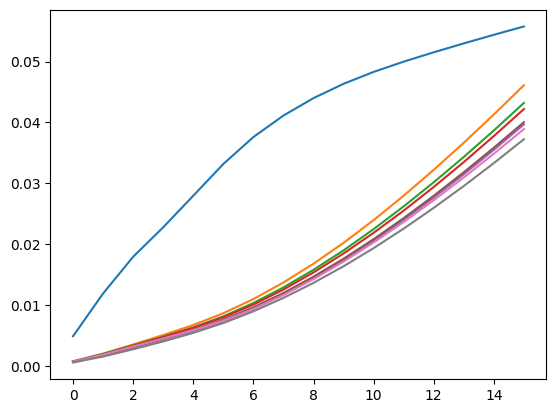

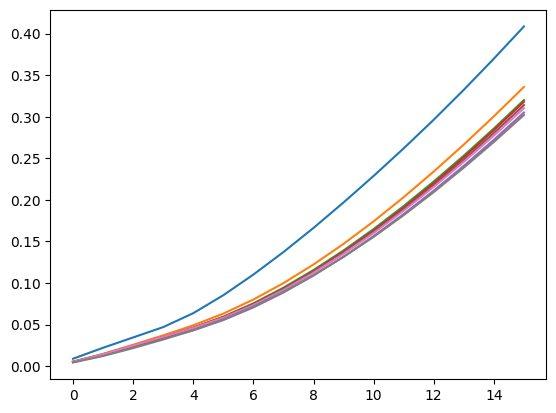

In [ ]:
def random_sample(data, labels, qty=1000, num_samples=1):
    ans_data = []
    ans_labels = []
    dataset_size = data.shape[0]
    for i in range(num_samples):
        listed = np.random.choice(range(dataset_size), qty, replace=False)
        ans_data.append(np.take(data, listed, axis=0))
        ans_labels.append(np.take(labels, listed, axis=0))
    return np.stack(ans_data), np.stack(ans_labels)

def random_sample_some_removed(data, labels, qty=1000, samples_removed=1, num_samples=1):
    ans_data = []
    ans_labels = []
    dataset_size = data.shape[0]
    sample_pool = np.random.choice(range(dataset_size), qty, replace=False)
    for i in range(num_samples):
        listed = np.random.choice(sample_pool, qty-samples_removed, replace=False)
        ans_data.append(np.take(data, listed, axis=0))
        ans_labels.append(np.take(labels, listed, axis=0))
    return np.stack(ans_data), np.stack(ans_labels)

def grade_prediction_single_channel(prediction, truth):
    return int(prediction) == int(truth)

def grade_prediction_one_hot(prediction, truth):
    return truth[np.argmax(prediction)] == 1

def grade_prediction_context_sensitive(prediction, truth):
    if one_hot:
        return grade_prediction_one_hot(prediction, truth)
    else:
        return grade_prediction_single_channel(prediction, truth)

def get_accuracy(output, ground_truth, grader = grade_prediction_context_sensitive):
    samples = output.shape[0]
    successes = 0
    for sample in range(samples):
        if grader(output[sample], ground_truth[sample]):
            successes += 1
    return successes/samples

def linear_regression(train_data, train_ans):
    if len(train_ans.shape) <= 2: # If data is not 1-hot
        return np.linalg.lstsq(train_data, train_ans)[0]
    ans = []
    for batch in range(train_ans.shape[0]):
        ans.append(np.linalg.lstsq(train_data[batch], train_ans[batch])[0])
    return np.stack(ans)

def test_samples(data_samples, label_samples):
    test_samples_separate_train(data_samples, label_samples, data_samples, label_samples)

def test_samples_separate_train(train_in, train_ans, test_in, test_ans, fast_noise=False):
    coeffs_list = []
    train_error_pre_noise = []
    test_error_pre_noise = []
    for i in range(train_in.shape[0]):
        coeffs = np.linalg.lstsq(train_in[i], train_ans[i])[0]
        train_results = np.matmul(train_in[i], coeffs)
        print("Train:")
        print("Train accuracy: ", get_accuracy(train_results, train_ans[i]))
        print(math.sqrt((train_results**2).mean()))
        error = math.sqrt(((train_results - train_ans[i])**2).mean())
        train_error_pre_noise.append(error)
        print(error)
        print("Test:")
        ans = np.matmul(test_in, coeffs)
        print("Test accuracy: ", get_accuracy(ans, test_ans))
        print(math.sqrt((ans**2).mean()))
        error = math.sqrt(((ans - test_ans)**2).mean())
        test_error_pre_noise.append(error)
        print(error)
        coeffs_list.append(coeffs)

    coeffs = np.stack(coeffs_list).squeeze()
    if fast_noise:
        noise = gen_noise2(torch.Tensor(coeffs).to(device), q=train_in.shape[0], noise_mult=1)
        noise = np.array(noise.cpu())
        noise = np.expand_dims(noise, 0).repeat(train_in.shape[0], 0) # Uses many copies of the same noise
    else:
        # noise = generate_gaussian_noise(cov(torch.Tensor(coeffs).to(device)), noise_mult=1, copies=train_in.shape[0]) # uses many different sets of noise
        noise = generate_gaussian_noise(cov(torch.Tensor(coeffs).to(device)), noise_mult=1)
        noise = np.array(noise.cpu())
        noise = noise.repeat(5, 0) # Uses many copies of the same noise
    coeffs = np.expand_dims(np.add(coeffs, noise), 2)
    train_error_post_noise = []
    test_error_post_noise = []

    for i in range(train_in.shape[0]):
        train_ans = np.matmul(train_in[i], coeffs)
        print("Train:")
        print("Train accuracy: ", get_accuracy(train_results, train_ans[i]))
        print(math.sqrt((train_ans**2).mean()))
        error = math.sqrt(((train_ans - train_ans[i])**2).mean())
        train_error_post_noise.append(error)
        print(error)
        print("Test:")
        ans = np.matmul(test_in, coeffs[i])
        print("Test accuracy: ", get_accuracy(ans, test_ans))
        print(math.sqrt((ans**2).mean()))
        error = math.sqrt(((ans - test_ans)**2).mean())
        test_error_post_noise.append(error)
        print(error)

    return sum(test_error_pre_noise) / len(test_error_pre_noise), sum(test_error_post_noise) / len(test_error_post_noise)

def test_stability(train_in, train_ans, num_removed = None, printout = True, train_printout = True, test_data = None, test_ans = None):
    """
    Returns a tuple whose first element is the average model l2 norm and whose
    second element is the standard deviation of l2 norms.
    """
    coeffs_list = []
    for i in range(train_in.shape[0]):
        coeffs = np.linalg.lstsq(train_in[i], train_ans[i])[0]
        if train_printout:
            train_results = np.matmul(train_in[i], coeffs)
            print("Train accuracy: ", get_accuracy(train_results, train_ans[i]))
        if test_data is not None and test_ans is not None:
            test_results = np.matmul(test_data, coeffs)
            print("Test accuracy: ", get_accuracy(test_results, test_ans))
        coeffs_list.append(coeffs)

    coeffs = np.stack(coeffs_list).squeeze()
    coeffs_list = [i.flatten() for i in coeffs_list]
    coeffs_norms = [math.sqrt(np.dot(i, i)) for i in coeffs_list]

    num_trials = len(coeffs_norms)

    avg_coeff = sum(coeffs_list)/num_trials
    coeff_diffs_list = [i-avg_coeff for i in coeffs_list]
    coeffs_diffs_norms = [math.sqrt(np.dot(i, i)) for i in coeff_diffs_list]

    avg_l2 = sum(coeffs_norms)/num_trials
    avg_l2_deviation = sum(coeffs_diffs_norms)/num_trials

    if printout:
        print("")
        if num_removed == None:
            print(f"{num_trials} were conducted. Each trial contained {train_in.shape[1]} data points.")
            print(f"Average l2 norm was {avg_l2:.2f}. We expect the average deviation to be equal to the average multiplied by the fraction of samples removed (e.g. for removing 1 sample from a set of 1000, divide by 1000)")
        else:
            print(f"{num_trials} trials were conducted. A bank of {train_in.shape[1]+num_removed} data points was used with each trial omitting {num_removed} data points")
            print(f"Average l2 norm was {avg_l2:.2f}. We expect the average deviation to be equal to 1/{(train_in.shape[1]+num_removed)/num_removed}")
        print(f"Average l2 norm deviation was {avg_l2_deviation:.2f}. This is equal to {100*avg_l2_deviation/avg_l2:.4f}% of the average l2 norm, or 1/{avg_l2/avg_l2_deviation:.1f}")

    return avg_l2, avg_l2_deviation

def multitest_stability(train_set, ans_set, dataset_sizes=(math.pow(2, i) for i in range(6, 16)), nums_removed=(math.pow(2, i) for i in range(15)), samples_per_trial=25, plot=True, status_printouts=True):
    print("Beginning stability testing")
    l2_results = np.zeros((len(dataset_sizes), len(nums_removed)))
    l2_deviation_results = np.zeros((len(dataset_sizes), len(nums_removed)))
    for i, dataset_size in enumerate(dataset_sizes):
        for j, num_removed in enumerate(nums_removed):
            if num_removed >= dataset_size:
                continue
            if status_printouts:
                print(f"Now calculating with {dataset_size} total samples and {num_removed} samples removed per trial.")
            in_samples, out_samples = random_sample_some_removed(train_mat, ans_mat, dataset_size, num_removed, samples_per_trial)
            l2, deviation = test_stability(in_samples, out_samples, num_removed, printout=False, train_printout=False)
            l2_results[i, j] = l2
            l2_deviation_results[i, j] = deviation
    if plot:
        x_labels = [f"{i} removed" for i in nums_removed]
        y_labels = [f"{i} datapoints" for i in dataset_sizes]

        create_heatmap(l2_results, x_labels, y_labels, "L2 norm")
        create_heatmap(l2_deviation_results, x_labels, y_labels, "L2 deviation")

        deviation_fraction = np.divide(l2_deviation_results, l2_results)
        create_heatmap(deviation_fraction, x_labels, y_labels, "L2 deviation as a fraction of L2 norm")

        theoretical_deviation = np.array([[0 if j >= i else j/i for j in nums_removed] for i in dataset_sizes])
        create_heatmap(theoretical_deviation, x_labels, y_labels, "Theoretical expected deviation")

        deviation_efficacy = np.divide(deviation_fraction, theoretical_deviation)
        create_heatmap(deviation_efficacy, x_labels, y_labels, "Ratio of observed to expected deviation")

    return l2_results, l2_deviation_results

test_mat = scipy.io.loadmat('data_cifar100_test.mat', verify_compressed_data_integrity=False)["data"]
ans_mat_test = scipy.io.loadmat('label_test.mat')["data"].transpose()
if one_hot:
    ans_mat_test = convert_to_one_hot(ans_mat_test)

# in_samples, out_samples = random_sample(train_mat, ans_mat, 20000, 2)
# test_stability(in_samples, out_samples, None, True, True, test_mat, ans_mat_test)

if run_multitest:
    dataset_sizes = (2048, 4096, 8092, 16184, 32368, 50000)
    nums_removed = (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8092, 16184)
    samples_per_trial = 16
    results = multitest_stability(train_mat, ans_mat, dataset_sizes, nums_removed, samples_per_trial, False)

# samples=100
# num_removed=1
# total_dataset_size=10000
# in_samples, out_samples = random_sample_some_removed(train_mat, ans_mat, total_dataset_size, num_removed, samples)
# test_stability(in_samples, out_samples, num_removed, train_printout=False)

# pre, post = test_samples_separate_train(in_samples, out_samples, test_mat, ans_mat_test, fast_noise=True)
# print(pre)
# print(post)

# TODO when using small amounts of (raw, doing this with preprocessed data would be v. bad) data, use data augmentation (e.g. flip, crop, etc.) to act as if we have large amounts of data.
# TODO compare 128 epochs in 8 groups to 128 epochs normally. Plot stability on the same graph.
# TODO this is the important one. From here on out, train a Resnet with 1,000 samples per group, 25 groups TODO add noise after each group proportional to l2 norm of that group. fine-tune # steps per group for maxmial privacy-utility tradeoff. TODO also try this with group-sample clipping.
# TODO noise for the above is gaussian noise with norm equal to absolute l2 deviation.

if run_training_divergence:
    stability_data = []
    for run_data in ((0, 0),): # ((10, 1.0), (25, 1.0), (100, 1.0), (400, 1.0)): # ((10, 3.0), (25, 2.25), (100, 1.5), (400, 1.0)):
        stability_data.append(train_models_checkpointed(train_mat, ans_mat, test_mat, ans_mat_test, 10000, 16, 16, 8, run_data[0], run_data[1], True))

In [ ]:
if run_multitest:
    x_labels = [f"{i} removed" for i in nums_removed]
    y_labels = [f"{i} datapoints" for i in dataset_sizes]
    create_heatmap(results[0], x_labels, y_labels, "L2 norm")
    create_heatmap(results[1], x_labels, y_labels, "L2 deviation")
    deviation_fraction = np.divide(results[1], results[0])
    create_heatmap(deviation_fraction, x_labels, y_labels, "L2 deviation as a fraction of L2 norm")
    theoretical_deviation = np.array([[0 if j >= i else j/i for j in nums_removed] for i in dataset_sizes])
    create_heatmap(theoretical_deviation, x_labels, y_labels, "Theoretical expected deviation")
    deviation_efficacy = np.divide(deviation_fraction, theoretical_deviation)
    create_heatmap(deviation_efficacy, x_labels, y_labels, "Ratio of observed to expected deviation", 2)

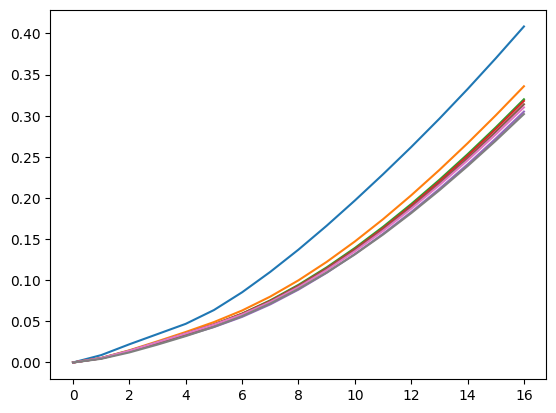

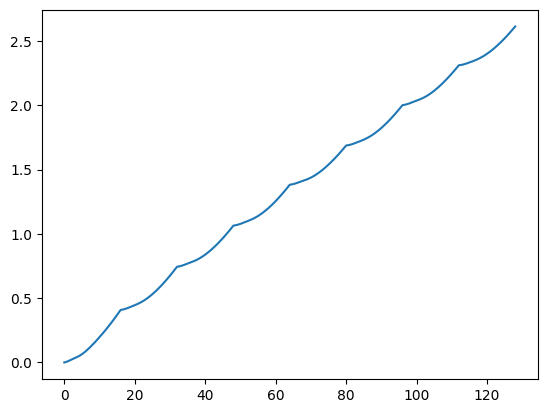

In [ ]:
for hyperparams in stability_data:
    for series in hyperparams:
        plt.plot([0] + [i[1] for i in series])
    plt.show()
for hyperparams in stability_data:
    list_of_points = [0]
    for series in hyperparams:
        previous_stopping_point = list_of_points[-1]
        list_of_points.extend([i[1]+previous_stopping_point for i in series])
    plt.plot(list_of_points)
    plt.show()

In [ ]:
for series in stability_data:
    for i in series:
        print(i[1], end=", ")

(1.860049244437646, 0.022126182488932652), (7.330253708230756, 0.014811876053636926), (7.29708002263839, 0.014325183915976366), (7.405090605957052, 0.01382154446470653), (7.542572589718509, 0.013510808708390654), (7.705151904365401, 0.013320687798145922), (7.8339201554861075, 0.014342375916819564), (7.975262464252789, 0.012213947487186629), 